In [1]:
import numpy as np
from matplotlib import pyplot as plt

from finalyze import GeoPointToXY
from finalyze import Point, MotionConstraints, SpeedPredictor, PumpController, PumpConstraints, BoundaryAction, GeoPoint
from finalyze import PolylineSampler

# Парсинг данных

## Вспомогательные функции

### Парсинг плана миссии

In [2]:
def parse_key_points_from_qgc_plan(plan: dict,
                                   include_home: bool = True,
                                   include_takeoff: bool = True,
                                   include_polygon: bool = True,
                                   include_transects: bool = True,
                                   deduplicate: bool = True) -> list[GeoPoint]:
    """
    Извлекает ключевые точки из QGC .plan:
      - plannedHomePosition
      - SimpleItem command=22 (взлёт) → params[4]=lat, params[5]=lon
      - ComplexItem 'survey' → polygon [[lat, lon], ...], старт с entryLocation (1-based)
      - ComplexItem 'survey' → TransectStyleComplexItem.VisualTransectPoints [[lat, lon], ...]
      - SimpleItem с coordinate (если есть)
    Возвращает GeoPointDTO(lon, lat, speed=0.0).
    """
    mission = plan.get("mission", {})
    items = mission.get("items", []) or []

    pts: list[GeoPoint] = []

    def add(lat: Optional[float], lon: Optional[float]):
        if lat is None or lon is None:
            return
        pts.append(GeoPoint(lon=float(lon), lat=float(lat)))

    # 1) Home
    if include_home:
        php = mission.get("plannedHomePosition")
        if isinstance(php, list) and len(php) >= 2:
            add(float(php[0]), float(php[1]))

    # 2) Takeoff (command 22)
    if include_takeoff:
        for it in items:
            if it.get("type") == "SimpleItem" and it.get("command") == 22:
                params = it.get("params", [])
                if isinstance(params, list) and len(params) >= 7:
                    add(float(params[4]), float(params[5]))
                break

    # 3,4) Survey polygon + VisualTransectPoints
    for it in items:
        if it.get("type") == "ComplexItem" and it.get("complexItemType") == "survey":
            if include_polygon:
                poly = it.get("polygon") or []
                verts: list[tuple[float, float]] = []
                for p in poly:
                    if isinstance(p, (list, tuple)) and len(p) >= 2:
                        verts.append((float(p[0]), float(p[1])))  # [lat, lon]
                if verts:
                    entry = it.get("entryLocation")
                    start = (entry - 1) if isinstance(entry, int) and 1 <= entry <= len(verts) else 0
                    ordered = verts[start:] + verts[:start]
                    for lat, lon in ordered:
                        add(lat, lon)
            if include_transects:
                tsc = it.get("TransectStyleComplexItem", {})
                vtp = tsc.get("VisualTransectPoints") or []
                for p in vtp:
                    if isinstance(p, (list, tuple)) and len(p) >= 2:
                        add(float(p[0]), float(p[1]))  # [lat, lon]
            break

    # 5) Прочие SimpleItem с coordinate
    for it in items:
        if it.get("type") == "SimpleItem":
            coord = it.get("coordinate")
            if isinstance(coord, list) and len(coord) >= 2:
                add(float(coord[0]), float(coord[1]))

    # 6) Дедупликация (по lat/lon)
    if deduplicate and pts:
        seen = set()
        uniq: list[GeoPoint] = []
        for p in pts:
            key = (round(p.lat, 8), round(p.lon, 8))
            if key in seen:
                continue
            seen.add(key)
            uniq.append(p)
        pts = uniq

    return pts


In [3]:
from pathlib import Path
from typing import Optional
import csv


# ====== Парсер CSV с ';' и десятичной ',' ======
def _to_float(s: str) -> Optional[float]:
    """Безопасное превращение строки с десятичной ',' в float. Пустые -> None."""
    if s is None:
        return None
    s = s.strip()
    if not s:
        return None
    # заменяем десятичную запятую на точку
    s = s.replace(',', '.')
    try:
        return float(s)
    except ValueError:
        return None


def parse_points_csv(
        path: Path,
        *,
        lat_col: int = 20,  # c20
        lon_col: int = 21,  # c21
        speed_col: int = 1  # c1 (текущая горизонтальная скорость)
) -> list[dict]:
    """
    Читает CSV и возвращает список PointDTO:
    - разделитель ';'
    - десятичная запятая ','
    - координаты берём из c20/c21 (lon/lat), скорость из c1
    - проекция: локальная AEQD вокруг первой валидной точки
    """
    # Сначала собираем геоточки
    geo_points = []
    with open(path, 'r', encoding='utf-8', newline='') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            # пропускаем пустые/короткие строки
            if not row or len(row) <= max(lon_col, lat_col, speed_col):
                continue
            lon = _to_float(row[lon_col])
            lat = _to_float(row[lat_col])
            speed = _to_float(row[speed_col])
            if lon is None or lat is None or speed is None:
                continue
            geo_points.append(dict(lon=lon, lat=lat, speed=speed))

    if not geo_points:
        # честно сообщаем о проблеме входных данных
        raise ValueError("Не найдено ни одной валидной строки c lon/lat/speed в заданных столбцах.")

    return geo_points


In [4]:
def scatter_with_color(p: list[Point], points_values: list[float], label="Скорость, м/с", cmap='plasma') -> None:
    xs, ys = zip(*p)
    sc = plt.scatter(xs, ys, c=points_values, cmap=cmap)
    plt.plot(xs, ys, '--')
    cbar = plt.colorbar(sc, fraction=0.1, pad=0.02)
    cbar.set_label(label)

In [5]:
from finalyze import polyline_lengths


def scatter_with_color_and_profile(p: list[Point], points_values: list[float], cmap='plasma', scatter_size=10) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1)

    path_x, path_y = zip(*p)
    sc = ax1.scatter(path_x, path_y, c=points_values, cmap=cmap, s=scatter_size)
    wp_x = [p.x for p in points]
    wp_y = [p.y for p in points]
    ax1.plot(wp_x, wp_y, linestyle="--", color="gray", alpha=0.3)
    ax1.set_xlabel("X, м")
    ax1.set_ylabel("Y, м")
    ax1.set_title("Траектория полёта (цвет = скорость, м/с)")
    fig.colorbar(sc, ax=ax1, label="скорость, м/с")

    ax2.plot(polyline_lengths(points), points_values, label="Скорость, м/с")
    ax2.set_xlabel("длина пути, м")
    ax2.set_ylabel("скорость, м/с")
    ax2.set_title("Профиль")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [6]:
def scatter(p: list[Point]) -> None:
    xs, ys = zip(*p)
    plt.plot(xs, ys, 'o--')

## Загрузка данных

In [7]:
# path_to_file = Path(r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250823_070453_421_bfb27ec8_e827_4223_b269_bcb6003c317d.json")
# path_to_file = Path(r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250823_080917_583_5626d8a6_8846_42c3_9e83_fc623fa61e77.json")
path_to_file = Path(r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250823_065052_535_7b16fa90_a27b_4f52_909c_d1f86fe0404a.json")

In [8]:
import json

with open(path_to_file, "r", encoding="utf-8") as f:
    data = json.load(f)

## Визуализация плана мисии

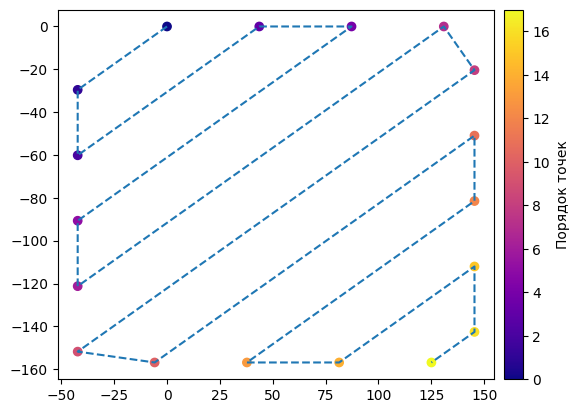

In [9]:
gp = parse_key_points_from_qgc_plan(
    data['mission']['mission_plan'],
    include_home=False,
    include_takeoff=False,
    include_polygon=False,
    include_transects=True,
    deduplicate=False,
)
# переводим гео координаты в xy
plan_points: list[Point] = GeoPointToXY.geo_to_xy(gp)
scatter_with_color(plan_points, list(range(len(plan_points))), 'Порядок точек')

## Реальный полёт

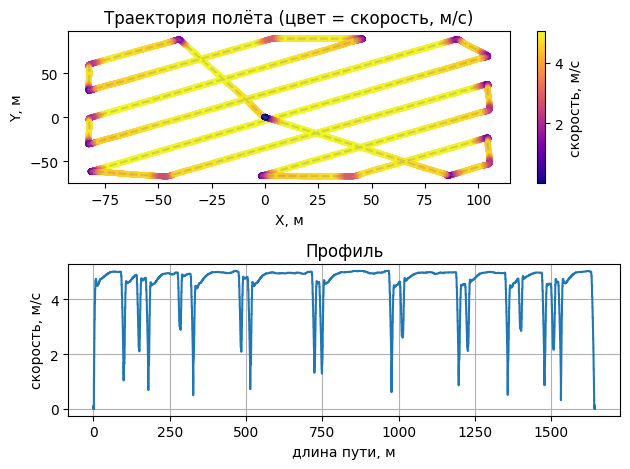

In [10]:
flights = data['flights']
points_by_flight = []

for f in flights:
    geo_points: list[GeoPoint] = []
    speed_list = []

    for s in f['samples']:
        if s['VehicleID'] != 1:
            continue
        telemetry = s['telemetry']
        p = telemetry['coordinate']
        geo_points.append(GeoPoint(lat=p['lat'], lon=p['lon']))
        speed_list.append(telemetry['speed']['groundSpeed'])

    # переводим гео координаты в xy
    points: list[Point] = GeoPointToXY.geo_to_xy(geo_points)

    scatter_with_color_and_profile(points, speed_list)

    plt.show()
    points_by_flight.append({'points': points, 'speed': speed_list})

## Предсказанный на основе плана

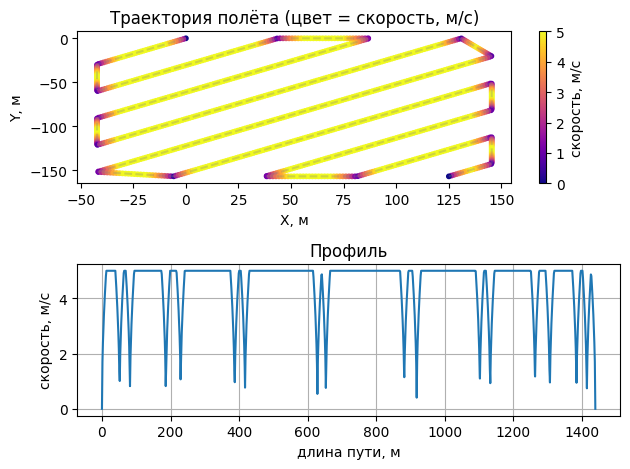

In [11]:
from finalyze import PureLateralLimitTurnPolicy
from finalyze import point_on_path

# waypoints = [Point(x,y) for x,y in ((0, 0), (20, 0), (50, 0), (50, 50), (100, 50))]
# waypoints = points_by_flight[0]['points']
waypoints = plan_points
motion = MotionConstraints(
    v_max=5.0,
    a_max=1.0,
    d_max=1.0,
    yaw_rate=90.0,
    turn_radius=0,
    a_lat_max=2.0,
    angle_eps_deg=10.0,
    start_speed=0.0,
    end_speed=0.0
)

predictor = SpeedPredictor(motion, PureLateralLimitTurnPolicy())
profile = predictor.build_profile(waypoints)

s_list = np.linspace(0, profile.total_distance, 1000)
points = [point_on_path(waypoints, d) for d in s_list]
scatter_with_color_and_profile(points, [profile.speed_at_distance(p) for p in s_list])

# Предсказания

Длина маршрута L = 1445.38 м
Плановый объём V_total = 120.00 л
Фактически выльется (с учётом ограничений насоса): 119.97 л
Моменты опустошения бака:
  t = 128.58 с, суммарно вылито 40.00 л
  t = 243.70 с, суммарно вылито 80.00 л


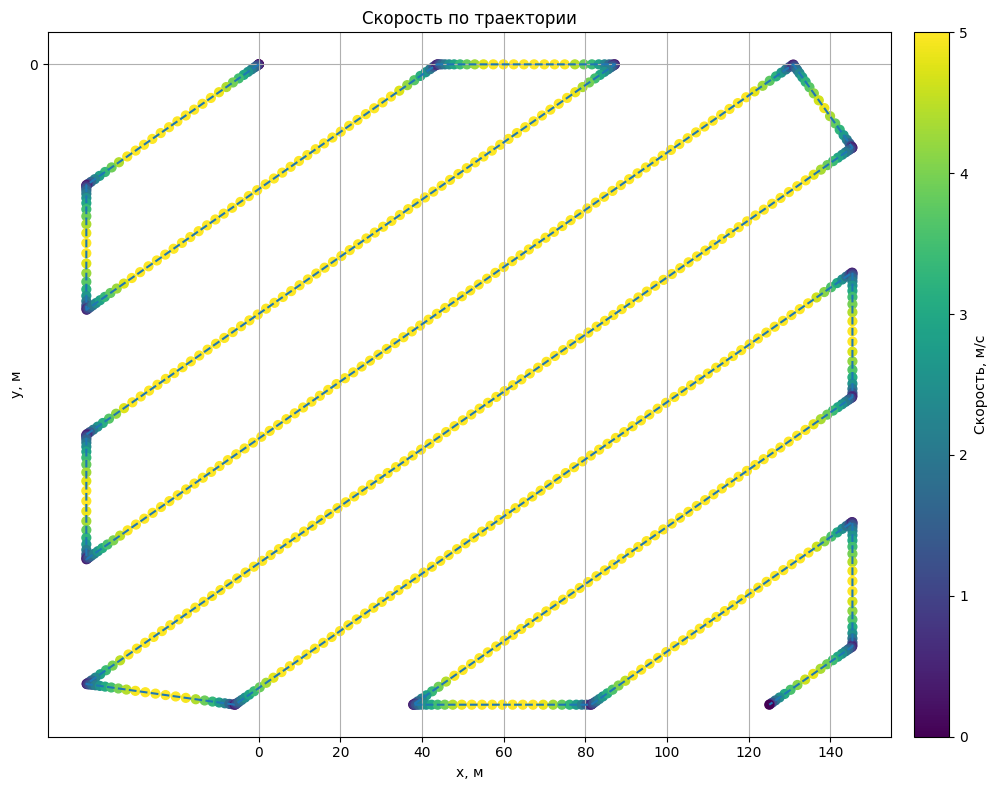

In [12]:
t_list, s_list, speed_list = profile.simulate_time_param(dt=0.5)

V_total = 120.0  # л — нужно вылить на всём маршруте

constraints = PumpConstraints(
    q_min=0.02,  # л/с
    q_max=2.5,  # л/с
    tank_volume=40.0,  # л
    low_mode=BoundaryAction.ZERO,
    high_mode=BoundaryAction.CLAMP,
)

pump = PumpController(constraints)

plan = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list,
    L=profile.total_distance,
    V_total=V_total,
)

# 5) Проверки/отчёт
print(f"Длина маршрута L = {profile.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(plan) :.2f} л")
if plan.empty_events:
    print("Моменты опустошения бака:")
    for t_empty, V_cum in plan.empty_events:
        print(f"  t = {t_empty:.2f} с, суммарно вылито {V_cum:.2f} л")
else:
    print("Бак не опустошается в ходе полёта.")

PolylineSampler.plot_trajectory_with_samples(waypoints, s_list, speed_list)